In [1]:
import os
import shutil
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models
from PIL import Image

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import *
import seaborn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
dataset_main_path = '/content/gdrive/MyDrive/AllData/Xray_Dataset/'

In [4]:
def load_aug_data(batch_size=64):
    # Define a transform function that resizes images to 224x224
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                                  torchvision.transforms.ToTensor()])

    # Load training, validation and test data 
    train_data = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
    val_data = torchvision.datasets.ImageFolder(dataset_main_path+'Validation', transform=transform)
    test_data = torchvision.datasets.ImageFolder(dataset_main_path+'Test', transform=transform)

    # Training Data is augmented using three techniques
    aug_types = [torchvision.transforms.RandomRotation(random.randint(0,10)),                  
                torchvision.transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)), 
                torchvision.transforms.RandomHorizontalFlip(1)]

    # Create augmented training data
    end_index_1 = 512
    end_index_2 = 1024
    end_index_3 = 1536

    train_indices = [list(range(0, end_index_1)), 
                    list(range(end_index_1, end_index_2)), 
                    list(range(end_index_2, end_index_3))]

    
    transform = torchvision.transforms.Compose([aug_types[0],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.ToTensor()])
    aug_dataset_1 = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
    aug_dataset_subset_1 = torch.utils.data.Subset(aug_dataset_1, train_indices[0])
    #train_data_new_1 = torch.utils.data.ConcatDataset([train_data, aug_dataset_subset_1])

    transform = torchvision.transforms.Compose([aug_types[1],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.ToTensor()])
    aug_dataset_2 = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
    aug_dataset_subset_2 = torch.utils.data.Subset(aug_dataset_2, train_indices[1])
    #train_data_new_2 = torch.utils.data.ConcatDataset([train_data, aug_dataset_subset])

    transform = torchvision.transforms.Compose([aug_types[2],
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.ToTensor()])
    aug_dataset_3 = torchvision.datasets.ImageFolder(dataset_main_path+'Train', transform=transform)
    aug_dataset_subset_3 = torch.utils.data.Subset(aug_dataset_3, train_indices[2])
    train_data_new = torch.utils.data.ConcatDataset([train_data, 
                                                     aug_dataset_subset_1, 
                                                     aug_dataset_subset_2, 
                                                     aug_dataset_subset_3])
    
    print('Training data:', len(train_data))
    print('Training Augmented data:', len(train_data_new))
    print('Validation data:',len(val_data))
    print('Testing data:',len(test_data))

    # The loaders with the augmented data
    train_loader = torch.utils.data.DataLoader(train_data_new, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader



### ResNet50 

In [5]:
resnet50 =torchvision.models.resnet50(pretrained=True)
n_inputs = resnet50.fc.in_features

for param in resnet50.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [6]:
resnet50.fc = nn.Sequential(
                      nn.Linear(n_inputs , 1024),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.Linear(1024 , 512),
                      nn.Linear(512 , 4))

### Confusion Matrix Plotting

In [7]:
def get_accuracy_mat(model, data_loader):
    correct = 0
    total = 0
    
    # List of all the labels
    predicted_labels = [] # List of predictions made by model
    true_labels = []      # List of labels for images seen by model
    
    for imgs, labels in data_loader:
         
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        # Adding the labels/predictions
        predicted_labels.extend(pred.tolist())  # Adds model prediction to list
        true_labels.extend(labels.tolist())     # Adds true label to list

    # Creates the normalized confusion matrix (remove normalize='true' flag for unnormalized) 
    matrix = pd.DataFrame(confusion_matrix(true_labels,predicted_labels,normalize=None),['COVID-19', 'Normal', 'Pneumonial-Bacterial','Pneumonial-Viral'],
                          ['COVID-19', 'Normal', 'Pneumonial-Bacterial','Pneumonial-Viral'])

    # Visual representation of matrix
    seaborn.heatmap(matrix, annot=True, fmt='g', cbar=False, cmap="YlGnBu")
    
    # Returns accuracy 
    return correct / total

In [8]:
bs = 64
train_loader, val_loader, test_loader = load_aug_data(batch_size=bs)

Training data: 3080
Training Augmented data: 4616
Validation data: 1020
Testing data: 1024


In [9]:
resnet50_model = torchvision.models.resnet50(pretrained=True)
n_inputs = resnet50_model.fc.in_features

for param in resnet50_model.parameters():
  param.requires_grad = False

resnet50_model.fc = nn.Sequential(
                      nn.Linear(n_inputs , 1024),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.Linear(1024 , 512),
                      nn.Linear(512 , 4))
state = torch.load('/content/gdrive/MyDrive/Training_Results/trial_2/model_2/model_resnet50_bs64_lr0.0001_epoch2')
resnet50_model.load_state_dict(state)

<All keys matched successfully>

Test Accuracy of resnet50: 0.7978515625


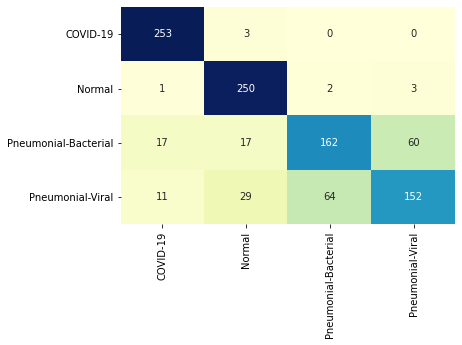

In [10]:
acc = get_accuracy_mat(resnet50_model, test_loader)
print("Test Accuracy of resnet50:", acc)